In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
import pandas as pd
np.set_printoptions(threshold=50, edgeitems=20)

PATH = 'data/'

In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [4]:
from biopandas.pdb import PandasPdb

In [5]:
df = pd.read_pickle('df1.pkl')

In [6]:
df.columns

Index(['atom_number', 'atom_name', 'residue_name', 'chain_id',
       'residue_number', 'x_coord', 'y_coord', 'z_coord', 'b_factor'],
      dtype='object')

In [9]:
df.head(100)

,atom_number,atom_name,residue_name,chain_id,residue_number,x_coord,y_coord,z_coord,b_factor
0,862,N,MET,A,113,-53.020,142.882,21.744,28.08
1,863,CA,MET,A,113,-52.088,143.221,20.682,27.31
2,864,C,MET,A,113,-50.908,143.966,21.325,26.89
3,865,O,MET,A,113,-51.066,145.080,21.824,26.43
4,866,CB,MET,A,113,-52.816,144.112,19.682,29.47
5,867,CG,MET,A,113,-52.166,144.261,18.340,31.62
6,868,SD,MET,A,113,-52.186,142.722,17.415,37.10
7,869,CE,MET,A,113,-50.435,142.577,17.047,33.99
8,870,N,PRO,A,114,-49.710,143.365,21.313,26.55
9,871,CA,PRO,A,114,-48.520,143.985,21.907,28.47


In [7]:
from sklearn.utils import shuffle

In [8]:
df= shuffle(df)

In [9]:
cat_vars = ['atom_name', 'residue_name', 'chain_id',
       'residue_number']
contin_vars = ['x_coord', 'y_coord', 'z_coord']


In [10]:
for v in cat_vars: df[v] = df[v].astype('category').cat.as_ordered()


In [11]:
for v in contin_vars:
    df[v] = df[v].fillna(0).astype('float32')

In [12]:
# y=pd.DataFrame()
# y=df.drop(['atom_number', 'atom_name', 'residue_name', 'chain_id',
#        'residue_number','y_coord', 'z_coord', 'b_factor'],axis=1)

In [13]:
df=df.drop(['atom_number','y_coord', 'z_coord'],axis=1)

In [14]:
df.head()

,atom_name,residue_name,chain_id,residue_number,x_coord,b_factor
877,N,GLN,A,61,32.837002,43.15
438,C,GLU,A,208,49.514000,42.82
403,OG,SER,A,81,-20.426001,10.90
397,CD1,LEU,A,223,79.760002,41.60
126,CD,ARG,A,601,25.924999,95.07


In [15]:
df1, y, nas, mapper = proc_df(df, 'x_coord', do_scale=True)

In [16]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(len(df1) * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [17]:
#val_idx=[0]


In [18]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df1, y.astype(np.float32), cat_flds=cat_vars, bs=128)

In [19]:
cat_sz = [(c, len(df[c].cat.categories)+1) for c in cat_vars]

In [20]:
cat_sz

[('atom_name', 84),
 ('residue_name', 22),
 ('chain_id', 33),
 ('residue_number', 3687)]

In [21]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [22]:
emb_szs

[(84, 42), (22, 11), (33, 17), (3687, 50)]

In [23]:
m = md.get_learner(emb_szs, len(df1.columns)-len(cat_vars),
                   0.01, 1, [800,500], [0.0001,0.001])
lr = 1e-3

In [24]:
m.lr_find()

 85%|████████▌ | 19440/22821 [01:30<00:15, 215.99it/s, loss=1.04e+06]

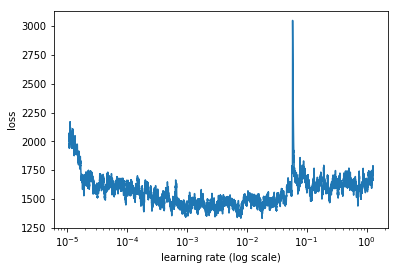

In [25]:
m.sched.plot(100)

In [33]:
m.load('m_best')


  4%|▎         | 812/22821 [00:23<10:47, 33.97it/s, loss=1.18e+03]

In [36]:
print(m.predict_with_targs(val_idx[1:10000]))

TypeError: 'NoneType' object is not iterable

In [37]:
x,y=m.predict_array.plot

In [42]:
print()

[[-12.51609]
 [ 78.63062]
 [ -1.89209]
 [ 18.46762]
 [ 50.98215]
 [-29.57766]
 [ -9.74328]
 [  4.78527]
 [-12.95795]
 [ 23.47775]
 [-10.54917]
 [ 35.5491 ]
 [ 10.92635]
 [-37.66557]
 [-18.37857]
 [ 15.05736]
 [ 18.68637]
 [ 17.28552]
 [-13.22563]
 [-16.0357 ]
 ...
 [ -3.36434]
 [-14.27063]
 [ 11.03815]
 [ -3.21131]
 [ 42.35258]
 [-44.76463]
 [ 19.60537]
 [  1.79889]
 [-34.27273]
 [ 19.18748]
 [ 32.09142]
 [ 24.33587]
 [ 13.44489]
 [ -5.32663]
 [-30.56151]
 [  0.07158]
 [  3.87433]
 [-13.6752 ]
 [  0.02345]
 [ 40.0261 ]]


In [12]:
??proc_df